In [23]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy import misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import PIL
from PIL import Image
import scipy.misc
import random
import pandas as pd
import tensorflow as tf
import h5py



Need a function to clean image data and open matlab files.  Found this on github using the h5py package

In [24]:
# Found this function on github @username
def get_data_boxes(dsf, start_range, end_range):    
    
    dsf_name = dsf['digitStruct']['name']
    dsf_box = dsf['digitStruct']['bbox']
    train_data_boxes = {}
    
    for i in range(start_range, end_range):
        img_file = dsf[dsf_name[i][0]].value.tostring().replace("\x00","")
        boxes = []
        boxes_count = len(dsf[dsf_box[i].item()]["label"])
        if boxes_count > 1:
            for j in range(boxes_count):
                box = {}
                box["top"] = dsf[dsf[dsf_box[i].item()]["top"].value[j].item()].value[0][0]
                box["left"] = dsf[dsf[dsf_box[i].item()]["left"].value[j].item()].value[0][0]
                box["height"] = dsf[dsf[dsf_box[i].item()]["height"].value[j].item()].value[0][0]
                box["width"] = dsf[dsf[dsf_box[i].item()]["width"].value[j].item()].value[0][0]
                box["label"] = dsf[dsf[dsf_box[i].item()]["label"].value[j].item()].value[0][0]
                boxes.append(box)
        else:
            box = {}
            box["top"] = dsf[dsf_box[i].item()]["top"].value[0][0]
            box["left"] = dsf[dsf_box[i].item()]["left"].value[0][0]
            box["height"] = dsf[dsf_box[i].item()]["height"].value[0][0]
            box["width"] = dsf[dsf_box[i].item()]["width"].value[0][0]
            box["label"] = dsf[dsf_box[i].item()]["label"].value[0][0]            
            boxes.append(box)
    
        train_data_boxes[img_file] = boxes    
    
    return train_data_boxes

Writing function to extract bounding box labels, and format data, modification of step 2

The function extract the outer four corners of the digits

In [29]:
#fucntion to clean and simplify image
def greyscale_resize_bb(path, img_name, bbox, new_size_y, new_size_x, i = 0):
    
    #change 10 label to 0
    def get_label(bbox):
        y = [str(int(i['label'])) for i in bbox]
        y = ['0' if i == '10' else i for i in y]
        y = ''.join(y)
        return y
    
    label = get_label(bbox[img_name])
    
    try:
        #convert image to array
        filename = path + img_name
        img = Image.open(filename)
        img = misc.fromimage(img, flatten = True)
        img = np.array(img)

        L1 = bbox[img_name][0]['left']
        L2 = bbox[img_name][-1]['left']
        H1 = bbox[img_name][0]['height']
        H2 = bbox[img_name][-1]['height']
        W1 = bbox[img_name][0]['width']
        W2 = bbox[img_name][-1]['width']
        T1 = bbox[img_name][0]['top']
        T2 = bbox[img_name][-1]['top']

        #if image slanting up or down do the following
        if (T2-T1) < 0.: #slantup
            y_top = T2
            height = H1 + abs(H2-H1)
            y_bottom = T1 + height
            x_left = L1
            x_right = L2 + W2

        if (T2-T1) > 0: #slantdown
            y_top = T1
            height = H1 + abs(H2-H1)
            y_bottom = T2 + height + abs(H2-H1)
            x_left = L1
            x_right = L2 + W2

        if (T2 == T1) > 0: #length = 1
            y_top = T1
            y_bottom = T1 + H1
            x_left = L1
            x_right = L1 + W1
        
        #extract large box to localize all digits, then normalize to new size
        shape = img.shape
        y_top = y_top / shape[0] * new_size_y
        y_bottom = y_bottom / shape[0] * new_size_y
        x_left = x_left / shape[1] * new_size_x
        x_right = x_right / shape[1] * new_size_x
        bb = [y_top , y_bottom, x_left, x_right]
    
        #resize and normalize image
        img = scipy.misc.imresize(img, (new_size_y,new_size_x))
        img = img/float(img.max())
        
        #Some bbox data doesn't work for some reason, so I'm removing it, with the following 
        if (x_left == x_right):
            print('nodata', i)
            return 'nodata', label
        if (y_top == y_bottom):
            print('nodata', i)
            return 'nodata', label
        for k in bb:
            if k < 0:
                print('nodata', i)
                return 'nodata', label
            if k > 64:
                print('nodata', i)
                return 'nodata', label
                
        
        return img, label, bb
    except ValueError:
        print('nodata', i)
        return 'nodata', label
        

pickling bbox data

In [311]:
# test_size = 13068
test_size = 13068
f = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/test/digitStruct.mat'
test = h5py.File(f, 'r')
test_data_boxes = get_data_boxes(test, 0, test_size)

with open('test_bbox.pickle', 'wb') as f:
    pickle.dump(test_data_boxes, f, pickle.HIGHEST_PROTOCOL)
print('test_bbox pickeled')

train_size = 33402
f = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/train/digitStruct.mat'
data = h5py.File(f, 'r')
train_data_boxes = get_data_boxes(data, 0, train_size)

with open('train_bbox.pickle', 'wb') as f:
    pickle.dump(train_data_boxes, f, pickle.HIGHEST_PROTOCOL)
print('train_bbox pickeled')


test_bbox pickeled
train_bbox pickeled


In [26]:
test_bbox = pickle.load( open( "test_bbox.pickle", "rb" ) )
train_bbox = pickle.load( open( "train_bbox.pickle", "rb" ) )

Now processing imagefiles

In [30]:
#getting PNG filelist
train_path = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/train'
train_filelist = [f for f in os.listdir(train_path) if f.endswith('.png')]
test_path = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/test'
test_filelist = [f for f in os.listdir(test_path) if f.endswith('.png')]

#cropping, normalizing, and storing data in a list using the above function
test_path = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/test/'
test_data = [greyscale_resize_bb(test_path, test_filelist[i], test_bbox, 64, 64, i) for i in range(len(test_filelist))]
print('test done')
train_path = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/train/'
train_data = [greyscale_resize_bb(train_path, train_filelist[i], train_bbox, 64, 64, i) for i in range(len(train_filelist))]
print('train done')

nodata 43
nodata 350
nodata 1808
nodata 1993
nodata 2032
nodata 2476
nodata 2707
nodata 3034
nodata 3179
nodata 3892
nodata 4824
nodata 4863
nodata 5299
nodata 5482
nodata 5506
nodata 5541
nodata 5674
nodata 5781
nodata 6337
nodata 6827
nodata 6836
nodata 7450
nodata 7595
nodata 7748
nodata 7804
nodata 7951
nodata 8179
nodata 8226
nodata 8971
nodata 9059
nodata 9114
nodata 9288
nodata 9643
nodata 10033
nodata 10443
nodata 10987
nodata 11519
nodata 11614
nodata 11830
nodata 12766
nodata 12946
test done
nodata 970
nodata 1041
nodata 1121
nodata 1920
nodata 2052
nodata 2057
nodata 2070
nodata 2212
nodata 2228
nodata 2355
nodata 2431
nodata 2468
nodata 2505
nodata 2938
nodata 2966
nodata 3001
nodata 3092
nodata 3154
nodata 3156
nodata 3497
nodata 3712
nodata 3726
nodata 3755
nodata 3999
nodata 4169
nodata 4274
nodata 4550
nodata 4657
nodata 4684
nodata 5003
nodata 5217
nodata 5298
nodata 5401
nodata 5697
nodata 5762
nodata 5951
nodata 6224
nodata 6409
nodata 7030
nodata 7317
nodata 7661
no

bounding box:  [10.666666666666666, 53.333333333333336, 23.843137254901961, 41.411764705882355]
image number:  21


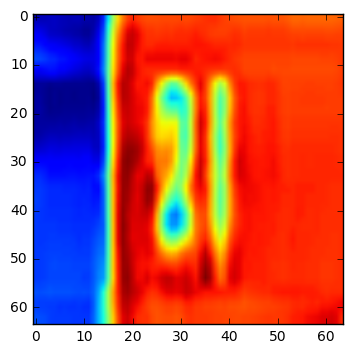

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


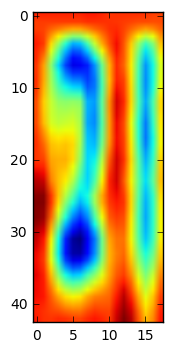

In [31]:
imgnumber = 200
bb = test_data[imgnumber][2]
print('bounding box: ', test_data[imgnumber][2])
print('image number: ', test_data[imgnumber][1])
plt.imshow(test_data[imgnumber][0])
plt.show()
plt.imshow(test_data[imgnumber][0][bb[0]:bb[1], bb[2] : bb[3]])
plt.show()


In [32]:
#pickling image data and labels
with open('test_data_part4.pickle', 'wb') as f:
    pickle.dump(test_data, f, pickle.HIGHEST_PROTOCOL)
print('test_data pickeled')

with open('train_data_part4.pickle', 'wb') as f:
    pickle.dump(train_data, f, pickle.HIGHEST_PROTOCOL)
print('train_bbox pickeled')


test_data pickeled
train_bbox pickeled
